In [74]:
import datetime
from geneformer import Classifier
from pathlib import Path

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = (
    f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"
)

output_prefix = "3_ind_classify"
output_dir = f"./{output_prefix}/{datestamp}"
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [75]:
training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay": 0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
    "epochs": 10,
}
cc = Classifier(
    classifier="cell",
    cell_state_dict={"state_key": "incident_cad", "states": "all"},
    filter_data=None,
    training_args=training_args,
    max_ncells=None,
    freeze_layers=2,
    num_crossval_splits=1,
    forward_batch_size=4,
    nproc=16,
)

In [76]:
# previously balanced splits with prepare_data and validate functions
# argument attr_to_split set to "individual" and attr_to_balance set to ["disease","lvef","age","sex","length"]
train_ids = list(range(128))
eval_ids = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
test_ids = [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

train_test_id_split_dict = {
    "attr_key": "eid",
    "train": train_ids + eval_ids,
    "test": test_ids,
}


cc.prepare_data(
    input_data_file="/home/xutingfeng/ukb/project/ppp_prediction/2_Data/GeneFormer/imputed/train",
    output_directory=output_dir,
    output_prefix=output_prefix,
    split_id_dict=train_test_id_split_dict,
    test_size=0.2,
)

Map (num_proc=16):   0%|          | 0/40806 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/40806 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/40806 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/128 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10 [00:00<?, ? examples/s]

In [6]:
# 6 layer Geneformer: https://huggingface.co/ctheodoris/Geneformer/blob/main/model.safetensors

model_used = "6_layer"
if model_used == "6_layer":
    model_directory = "/home/xutingfeng/github_code/others/Geneformer/"
elif model_used == "12_layer":
    model_directory = (
        "/home/xutingfeng/github_code/others/Geneformer/geneformer-12L-30M"
    )


all_metrics = cc.validate(
    model_directory=model_directory,  # 12L
    prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled_train.dataset",
    id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
    output_directory=output_dir,
    output_prefix=output_prefix,
    split_id_dict=None,
)

  0%|          | 0/1 [00:00<?, ?it/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/xutingfeng/github_code/others/Geneformer/ and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


****** Validation split: 1/1 ******



/home/xutingfeng/miniforge3/envs/work/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(
/home/xutingfeng/github_code/others/Geneformer/geneformer/collator_for_classification.py:581: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = {k: torch.tensor(v, dtype=torch.int64) for k, v in batch.items()}


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.629800,0.656620,0.884615,0.668085


  0%|          | 0/7 [00:00<?, ?it/s]

/home/xutingfeng/github_code/others/Geneformer/geneformer/evaluation_utils.py:190: SyntaxWarning: invalid escape sequence '\p'
  label = f"{model_name} (AUC {roc_auc:0.2f} $\pm$ {roc_auc_sd:0.2f})"


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'

In [2]:
import torch

torch.cuda.is_available()

True

In [2]:
from geneformer import perturber_utils as pu

model_used = "6_layer"
if model_used == "6_layer":
    model_directory = "/home/xutingfeng/github_code/others/Geneformer/"
elif model_used == "12_layer":
    model_directory = (
        "/home/xutingfeng/github_code/others/Geneformer/geneformer-12L-30M"
    )

from datasets import load_from_disk

train_dataset = load_from_disk(
    "/home/xutingfeng/ukb/project/ppp_prediction/2_Data/GeneFormer/imputed/test"
)

In [57]:
train_dataset.set_format(type="torch", columns=["input_ids", "incident_cad"])

In [6]:
from geneformer import classifier_utils as cu


cu.balance_attr_splits(
    train_dataset,
    "incident_cad",
    "incident_cad",
    0.2,
    100,
    0.1,
    "incident_cad",
    4,
)

KeyError: "Column i not in the dataset. Current columns in the dataset: ['input_ids', 'incident_cad', 'length']"

In [8]:
train_dataset[0]["incident_cad"].dtype
# dataloader = DataLoader(train_dataset, batch_size=32)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,


<Axes: ylabel='Count'>

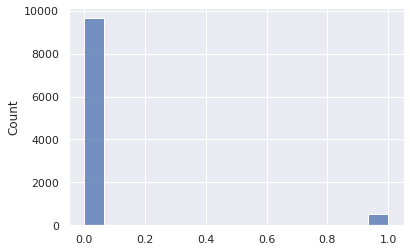

In [10]:
import seaborn as sns

sns.histplot(train_dataset["incident_cad"])

In [12]:
from sklearn.utils import class_weight
import numpy as np

class_weights = dict(
    enumerate(
        class_weight.compute_class_weight(
            "balanced",
            classes=np.unique(train_dataset["incident_cad"]),
            y=train_dataset["incident_cad"],
        )
    )
)
class_weights

{0: 0.528183607916278, 1: 9.370404411764707}

In [16]:
o

NameError: name 'o' is not defined

In [13]:
from torch.utils.data import DataLoader

train_dataset.set_format(type="torch", columns=["input_ids", "incident_cad"])
dataloader = DataLoader(train_dataset, batch_size=32)

In [14]:
idx = 1

for x, y in dataloader:
    break
print(x)

input_ids


In [17]:
model = pu.load_model("Pretrained", 2, model_directory, "eval")

In [18]:
from cadFace.utils import modelParametersNum

modelParametersNum(model)

模型总参数个数：10288722	占用的总显存为39.25MB


10288722

In [19]:
import torch

torch.randint(0, 2048, (10, 2048))

tensor([[1322, 1765,  725,  ...,  974,  504, 1596],
        [ 356, 1206, 1465,  ..., 1742,  746,  268],
        [1562, 1774,   47,  ...,  813, 1587, 1572],
        ...,
        [ 431, 1223, 1926,  ..., 1875, 1656,  182],
        [ 561, 1776, 1594,  ..., 1433, 1310, 1154],
        [  38,  518, 1219,  ..., 1514, 1794,  286]])

DEPRECATION: Loading egg at /home/xutingfeng/miniforge3/envs/work/lib/python3.12/site-packages/vit_pytorch-1.4.5-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/xutingfeng/miniforge3/envs/work/lib/python3.12/site-packages/tdigest-0.5.2.2-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/xutingfeng/miniforge3/envs/work/lib/python3.12/site-packages/typing_extensions-4.5.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /home/xutingfeng/min

In [69]:
train_dataset[0:2]["input_ids"].shape

torch.Size([2, 2048])

In [20]:
o = model(train_dataset[0:2]["input_ids"].to("cuda:0"))
o

MaskedLMOutput(loss=None, logits=tensor([[[-13.3080, -27.3790,  -0.7215,  ...,  -6.4295,  -8.1259, -14.5331],
         [-13.5671, -26.9814,  -0.8539,  ...,  -7.2701,  -8.0421, -14.6339],
         [-13.3982, -26.6502,  -0.4211,  ...,  -7.7244,  -7.8032, -14.5227],
         ...,
         [ -8.6814, -22.5568,   0.0971,  ...,  -5.9341,  -3.0241,  -9.6323],
         [ -8.9403, -24.6987,  -0.0362,  ...,  -6.2856,  -2.4822, -11.7524],
         [-10.5458, -24.6494,  -0.8618,  ...,  -7.5597,  -3.9908, -14.0862]],

        [[-12.5317, -26.3513,  -0.7492,  ...,  -6.1894,  -8.2421, -13.2152],
         [-12.2917, -26.1803,  -0.2618,  ...,  -6.1438,  -7.7144, -13.5522],
         [-12.0584, -25.0720,  -0.0952,  ...,  -5.8870,  -8.0170, -13.4369],
         ...,
         [ -9.8722, -24.2615,  -1.6960,  ...,  -2.7313,  -4.7234,  -9.3539],
         [ -9.2564, -22.8051,  -0.0491,  ...,  -2.4388,  -3.8614,  -9.0742],
         [-11.5466, -25.5968,   1.8902,  ...,  -7.8697,  -6.7447, -11.4963]]],
       devi

In [25]:
torch.rand((1, 2)).to(o.logits.device)

tensor([[0.2193, 0.9744]], device='cuda:0')

In [32]:
for x, y in dataloader:
    print(x, y)

input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids incident_cad
input_ids i

'incident_cad'

In [ ]:
from 
focal_loss = 

In [6]:
import pandas as pd

pd.read_pickle(
    "/home/xutingfeng/ukb/project/ppp_prediction/3_ind_classify/240324151736/3_ind_classify_id_class_dict.pkl"
)

{0: 0.0, 1: 1.0}

In [26]:
torch.tensor(1).

tensor(1)